# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

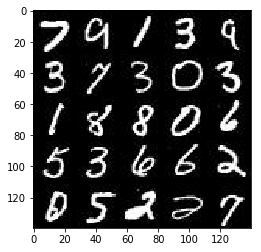

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

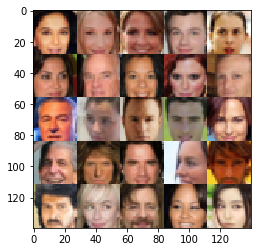

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = [image_width, image_height, image_channels]
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        
        #x0 = tf.layers.conv2d(images, 64, 3, strides=1, padding='same')
        #relu0 = tf.maximum(alpha * x0, x0)
        # 28x28x64
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
 
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
               
        #xm = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        #xm = tf.layers.batch_normalization(xm, training=is_train)
        #xm = tf.maximum(alpha * xm, xm)
        # 7x7x128 now
            
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
         
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs [x]
    :param batch_size: Batch Size [x]
    :param z_dim: Z dimension [x]
    :param learning_rate: Learning Rate [x]
    :param beta1: The exponential decay rate for the 1st moment in the optimizer [x]
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data [x]
    :param data_image_mode: The image mode to use for images ("RGB" or "L") [x]
    """
    batch_count = 0
    show_every = 200
    print_every = 50

    print(data_shape)
    _, image_width, image_height, image_channels = data_shape
    # TODO: Build Model
    
    # prepare input
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    # prepare loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    # prepare optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    #train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_count += 1
                
                # Sample noise from G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z, 
                                                     lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z, 
                                                     lr:learning_rate})

                if batch_count % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if batch_count % show_every == 0:
                    show_generator_output(sess, 
                                          n_images = 10, 
                                          input_z = input_z, 
                                          out_channel_dim = image_channels, 
                                          image_mode = data_image_mode)

 
                

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/4... Discriminator Loss: 1.1000... Generator Loss: 0.8284
Epoch 1/4... Discriminator Loss: 0.1833... Generator Loss: 2.2473
Epoch 1/4... Discriminator Loss: 0.2599... Generator Loss: 6.1736
Epoch 1/4... Discriminator Loss: 0.0256... Generator Loss: 11.1808


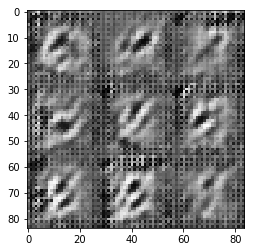

Epoch 1/4... Discriminator Loss: 0.2812... Generator Loss: 1.6908
Epoch 1/4... Discriminator Loss: 0.3861... Generator Loss: 1.9483
Epoch 1/4... Discriminator Loss: 0.1257... Generator Loss: 2.6852
Epoch 1/4... Discriminator Loss: 0.1100... Generator Loss: 3.2977


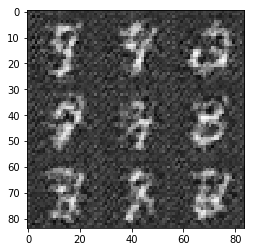

Epoch 1/4... Discriminator Loss: 0.7377... Generator Loss: 2.2571
Epoch 1/4... Discriminator Loss: 1.0654... Generator Loss: 0.6683
Epoch 1/4... Discriminator Loss: 0.5268... Generator Loss: 1.1239
Epoch 1/4... Discriminator Loss: 3.9821... Generator Loss: 5.1273


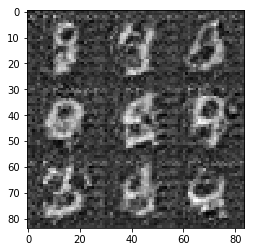

Epoch 1/4... Discriminator Loss: 0.6479... Generator Loss: 1.0710
Epoch 1/4... Discriminator Loss: 1.3078... Generator Loss: 3.1263
Epoch 1/4... Discriminator Loss: 0.4662... Generator Loss: 1.2205
Epoch 1/4... Discriminator Loss: 0.2536... Generator Loss: 1.9593


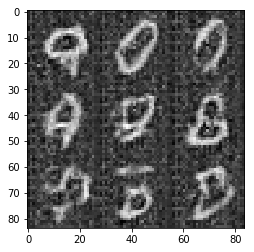

Epoch 1/4... Discriminator Loss: 0.7076... Generator Loss: 1.3788
Epoch 1/4... Discriminator Loss: 0.6858... Generator Loss: 0.9675
Epoch 1/4... Discriminator Loss: 0.5618... Generator Loss: 1.2312
Epoch 1/4... Discriminator Loss: 0.8535... Generator Loss: 0.7622


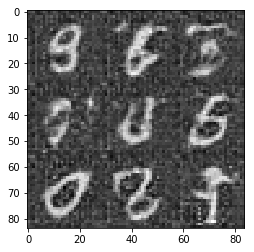

Epoch 1/4... Discriminator Loss: 0.4802... Generator Loss: 1.3431
Epoch 1/4... Discriminator Loss: 1.3247... Generator Loss: 0.5847
Epoch 1/4... Discriminator Loss: 0.0872... Generator Loss: 3.0051
Epoch 1/4... Discriminator Loss: 0.1521... Generator Loss: 2.9060


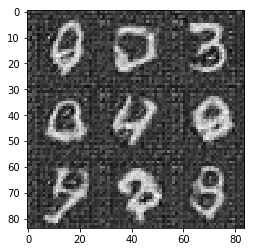

Epoch 1/4... Discriminator Loss: 0.4495... Generator Loss: 2.4117
Epoch 1/4... Discriminator Loss: 0.4685... Generator Loss: 1.3273
Epoch 1/4... Discriminator Loss: 0.3286... Generator Loss: 1.6251
Epoch 1/4... Discriminator Loss: 0.7629... Generator Loss: 0.8956


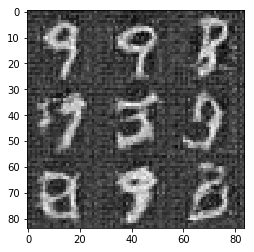

Epoch 1/4... Discriminator Loss: 1.6416... Generator Loss: 0.3348
Epoch 1/4... Discriminator Loss: 0.4521... Generator Loss: 1.8043
Epoch 1/4... Discriminator Loss: 0.6648... Generator Loss: 2.6914
Epoch 1/4... Discriminator Loss: 0.7533... Generator Loss: 0.9525


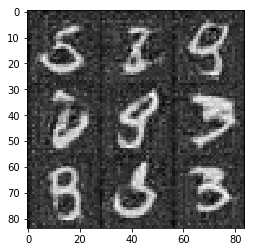

Epoch 1/4... Discriminator Loss: 0.3100... Generator Loss: 1.8030
Epoch 1/4... Discriminator Loss: 1.0200... Generator Loss: 0.6750
Epoch 1/4... Discriminator Loss: 0.2444... Generator Loss: 2.4658
Epoch 1/4... Discriminator Loss: 0.1510... Generator Loss: 3.0665


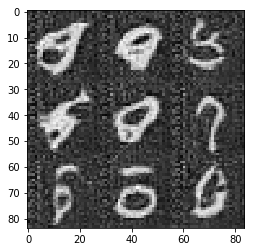

Epoch 1/4... Discriminator Loss: 0.7381... Generator Loss: 1.0040
Epoch 2/4... Discriminator Loss: 0.3978... Generator Loss: 2.0630
Epoch 2/4... Discriminator Loss: 0.3758... Generator Loss: 2.1425
Epoch 2/4... Discriminator Loss: 0.7406... Generator Loss: 0.9914


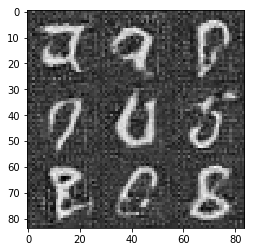

Epoch 2/4... Discriminator Loss: 1.3539... Generator Loss: 0.4510
Epoch 2/4... Discriminator Loss: 0.9080... Generator Loss: 0.7497
Epoch 2/4... Discriminator Loss: 0.6513... Generator Loss: 1.0727
Epoch 2/4... Discriminator Loss: 0.4193... Generator Loss: 1.6643


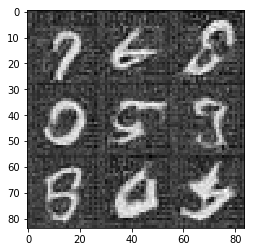

Epoch 2/4... Discriminator Loss: 0.7455... Generator Loss: 1.0956
Epoch 2/4... Discriminator Loss: 0.3524... Generator Loss: 1.7132
Epoch 2/4... Discriminator Loss: 3.0460... Generator Loss: 0.0862
Epoch 2/4... Discriminator Loss: 0.5259... Generator Loss: 2.0441


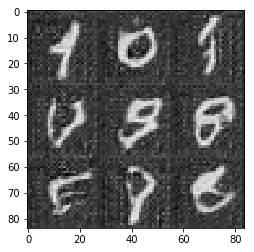

Epoch 2/4... Discriminator Loss: 0.5988... Generator Loss: 1.3845
Epoch 2/4... Discriminator Loss: 0.5138... Generator Loss: 1.5698
Epoch 2/4... Discriminator Loss: 0.5118... Generator Loss: 1.6672
Epoch 2/4... Discriminator Loss: 4.5681... Generator Loss: 0.0360


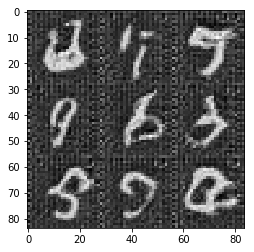

Epoch 2/4... Discriminator Loss: 0.4430... Generator Loss: 1.8531
Epoch 2/4... Discriminator Loss: 0.2365... Generator Loss: 3.4966
Epoch 2/4... Discriminator Loss: 0.5526... Generator Loss: 1.3785
Epoch 2/4... Discriminator Loss: 1.0085... Generator Loss: 0.6899


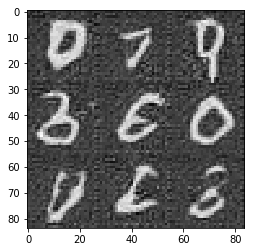

Epoch 2/4... Discriminator Loss: 0.1519... Generator Loss: 2.9413
Epoch 2/4... Discriminator Loss: 0.3473... Generator Loss: 2.0105
Epoch 2/4... Discriminator Loss: 0.1530... Generator Loss: 8.0638
Epoch 2/4... Discriminator Loss: 0.2230... Generator Loss: 3.1142


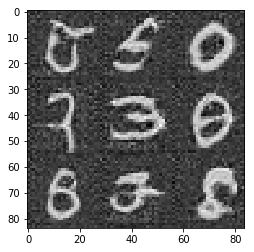

Epoch 2/4... Discriminator Loss: 0.8360... Generator Loss: 0.9466
Epoch 2/4... Discriminator Loss: 0.3777... Generator Loss: 1.8963
Epoch 2/4... Discriminator Loss: 0.0551... Generator Loss: 4.3855
Epoch 2/4... Discriminator Loss: 0.5161... Generator Loss: 2.2496


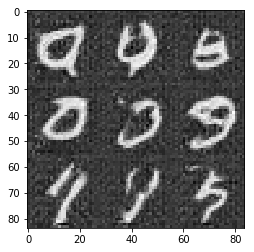

Epoch 2/4... Discriminator Loss: 0.8690... Generator Loss: 4.0475
Epoch 2/4... Discriminator Loss: 0.5857... Generator Loss: 1.2406
Epoch 2/4... Discriminator Loss: 0.6087... Generator Loss: 2.2713
Epoch 2/4... Discriminator Loss: 0.4465... Generator Loss: 1.5134


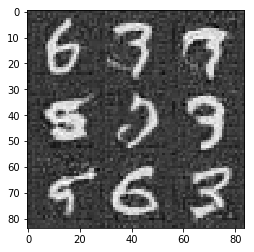

Epoch 2/4... Discriminator Loss: 0.6495... Generator Loss: 1.4570
Epoch 2/4... Discriminator Loss: 0.3014... Generator Loss: 2.3511
Epoch 2/4... Discriminator Loss: 0.3021... Generator Loss: 2.8986
Epoch 2/4... Discriminator Loss: 0.0322... Generator Loss: 5.3109


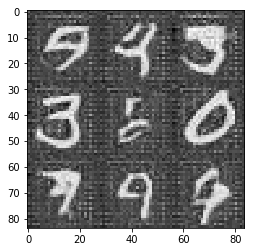

Epoch 2/4... Discriminator Loss: 0.1792... Generator Loss: 2.7801
Epoch 2/4... Discriminator Loss: 0.0237... Generator Loss: 5.2332
Epoch 2/4... Discriminator Loss: 0.2355... Generator Loss: 3.0912
Epoch 3/4... Discriminator Loss: 0.7421... Generator Loss: 1.1805


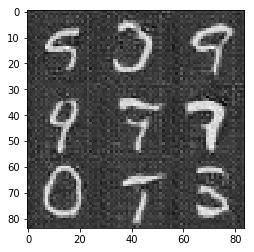

Epoch 3/4... Discriminator Loss: 0.2312... Generator Loss: 2.4248
Epoch 3/4... Discriminator Loss: 0.2965... Generator Loss: 2.2898
Epoch 3/4... Discriminator Loss: 0.0398... Generator Loss: 5.1448
Epoch 3/4... Discriminator Loss: 0.6975... Generator Loss: 1.2975


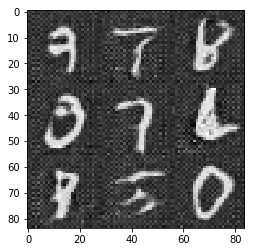

Epoch 3/4... Discriminator Loss: 1.0300... Generator Loss: 1.9453
Epoch 3/4... Discriminator Loss: 0.4241... Generator Loss: 3.9433
Epoch 3/4... Discriminator Loss: 1.0608... Generator Loss: 0.7527
Epoch 3/4... Discriminator Loss: 0.8130... Generator Loss: 0.9591


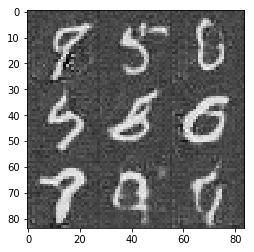

Epoch 3/4... Discriminator Loss: 0.3302... Generator Loss: 2.7323
Epoch 3/4... Discriminator Loss: 0.3577... Generator Loss: 2.3543
Epoch 3/4... Discriminator Loss: 0.1991... Generator Loss: 2.7881
Epoch 3/4... Discriminator Loss: 0.6116... Generator Loss: 1.3000


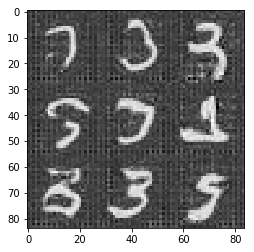

Epoch 3/4... Discriminator Loss: 0.0746... Generator Loss: 3.4174
Epoch 3/4... Discriminator Loss: 3.8387... Generator Loss: 8.9108
Epoch 3/4... Discriminator Loss: 0.4911... Generator Loss: 1.6208
Epoch 3/4... Discriminator Loss: 0.3602... Generator Loss: 1.9933


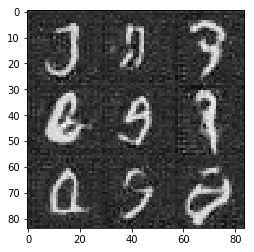

Epoch 3/4... Discriminator Loss: 0.6633... Generator Loss: 1.4142
Epoch 3/4... Discriminator Loss: 1.1796... Generator Loss: 0.8025
Epoch 3/4... Discriminator Loss: 1.2969... Generator Loss: 0.7895
Epoch 3/4... Discriminator Loss: 0.0358... Generator Loss: 5.3040


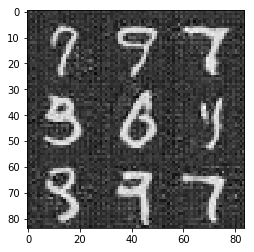

Epoch 3/4... Discriminator Loss: 1.2030... Generator Loss: 0.6253
Epoch 3/4... Discriminator Loss: 0.6267... Generator Loss: 1.2428
Epoch 3/4... Discriminator Loss: 0.5454... Generator Loss: 1.5726
Epoch 3/4... Discriminator Loss: 0.0503... Generator Loss: 4.0276


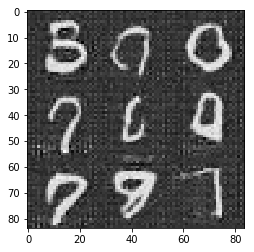

Epoch 3/4... Discriminator Loss: 0.2066... Generator Loss: 3.6530
Epoch 3/4... Discriminator Loss: 0.3537... Generator Loss: 1.9921
Epoch 3/4... Discriminator Loss: 0.4392... Generator Loss: 2.0262
Epoch 3/4... Discriminator Loss: 0.3389... Generator Loss: 2.2730


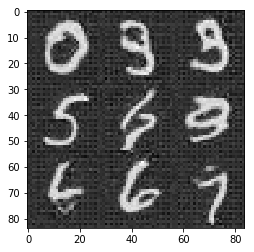

Epoch 3/4... Discriminator Loss: 0.0129... Generator Loss: 6.9672
Epoch 3/4... Discriminator Loss: 0.0104... Generator Loss: 10.6068
Epoch 3/4... Discriminator Loss: 0.1910... Generator Loss: 3.2421
Epoch 3/4... Discriminator Loss: 0.2320... Generator Loss: 2.6195


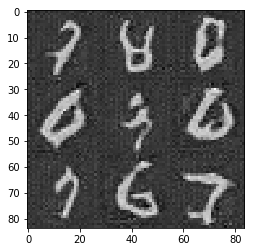

Epoch 3/4... Discriminator Loss: 0.5510... Generator Loss: 1.4450
Epoch 3/4... Discriminator Loss: 0.3198... Generator Loss: 2.4364
Epoch 3/4... Discriminator Loss: 0.3661... Generator Loss: 2.0394
Epoch 3/4... Discriminator Loss: 0.6562... Generator Loss: 1.3111


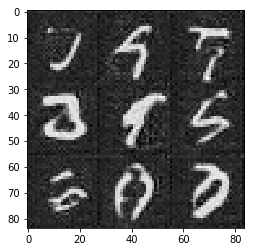

Epoch 4/4... Discriminator Loss: 0.4587... Generator Loss: 2.0370
Epoch 4/4... Discriminator Loss: 0.4427... Generator Loss: 1.5556
Epoch 4/4... Discriminator Loss: 0.2187... Generator Loss: 2.6077
Epoch 4/4... Discriminator Loss: 1.0261... Generator Loss: 0.9438


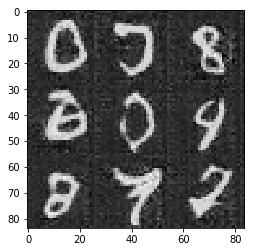

Epoch 4/4... Discriminator Loss: 1.9528... Generator Loss: 0.2548
Epoch 4/4... Discriminator Loss: 0.6573... Generator Loss: 1.4853
Epoch 4/4... Discriminator Loss: 0.1553... Generator Loss: 3.2304
Epoch 4/4... Discriminator Loss: 1.2482... Generator Loss: 0.7662


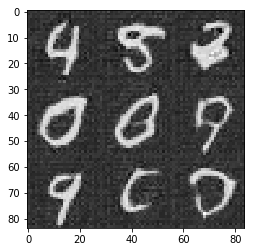

Epoch 4/4... Discriminator Loss: 0.4891... Generator Loss: 2.2165
Epoch 4/4... Discriminator Loss: 0.2375... Generator Loss: 3.4499
Epoch 4/4... Discriminator Loss: 0.4719... Generator Loss: 1.8610
Epoch 4/4... Discriminator Loss: 0.1260... Generator Loss: 3.3766


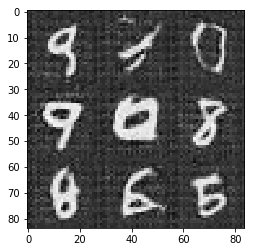

Epoch 4/4... Discriminator Loss: 0.5058... Generator Loss: 1.7895
Epoch 4/4... Discriminator Loss: 0.1044... Generator Loss: 3.7051
Epoch 4/4... Discriminator Loss: 0.0061... Generator Loss: 7.5586
Epoch 4/4... Discriminator Loss: 0.0579... Generator Loss: 4.3715


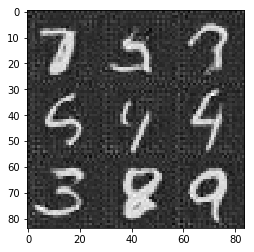

Epoch 4/4... Discriminator Loss: 0.0737... Generator Loss: 3.9531
Epoch 4/4... Discriminator Loss: 0.0440... Generator Loss: 4.7203
Epoch 4/4... Discriminator Loss: 0.1097... Generator Loss: 3.8272
Epoch 4/4... Discriminator Loss: 0.0040... Generator Loss: 6.4939


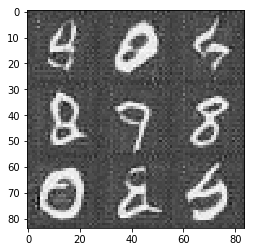

Epoch 4/4... Discriminator Loss: 0.1304... Generator Loss: 3.2483
Epoch 4/4... Discriminator Loss: 0.0444... Generator Loss: 4.6511
Epoch 4/4... Discriminator Loss: 0.1858... Generator Loss: 3.8223
Epoch 4/4... Discriminator Loss: 0.2265... Generator Loss: 2.9224


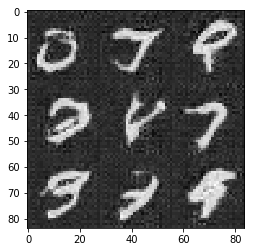

Epoch 4/4... Discriminator Loss: 0.2639... Generator Loss: 2.5760
Epoch 4/4... Discriminator Loss: 0.2912... Generator Loss: 2.1979
Epoch 4/4... Discriminator Loss: 0.6668... Generator Loss: 1.3204
Epoch 4/4... Discriminator Loss: 0.3901... Generator Loss: 3.9490


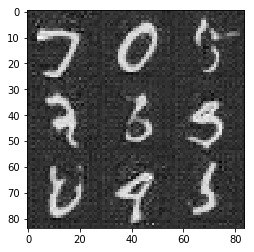

Epoch 4/4... Discriminator Loss: 0.3014... Generator Loss: 2.4710
Epoch 4/4... Discriminator Loss: 0.0697... Generator Loss: 4.9351
Epoch 4/4... Discriminator Loss: 0.3434... Generator Loss: 2.1095
Epoch 4/4... Discriminator Loss: 0.8202... Generator Loss: 1.1476


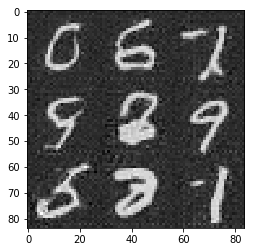

Epoch 4/4... Discriminator Loss: 0.2026... Generator Loss: 3.6960
Epoch 4/4... Discriminator Loss: 0.3684... Generator Loss: 2.1312
Epoch 4/4... Discriminator Loss: 0.0947... Generator Loss: 3.6582
Epoch 4/4... Discriminator Loss: 0.1021... Generator Loss: 3.3098


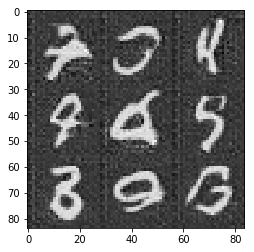

Epoch 4/4... Discriminator Loss: 0.2668... Generator Loss: 3.5842
Epoch 4/4... Discriminator Loss: 0.0054... Generator Loss: 6.6796


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    #tf.reset_default_graph()
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 0.7553... Generator Loss: 1.3693
Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 0.4497... Generator Loss: 1.4578


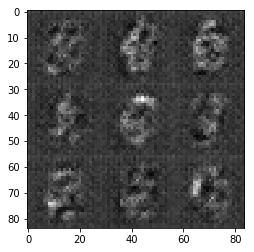

Epoch 1/2... Discriminator Loss: 0.3589... Generator Loss: 1.9300
Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 2.8680
Epoch 1/2... Discriminator Loss: 0.4671... Generator Loss: 1.7013
Epoch 1/2... Discriminator Loss: 0.4169... Generator Loss: 1.4296


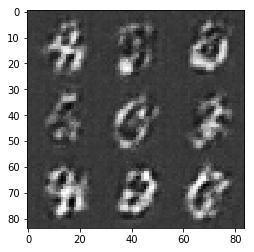

Epoch 1/2... Discriminator Loss: 0.2783... Generator Loss: 1.9885
Epoch 1/2... Discriminator Loss: 0.2589... Generator Loss: 2.1395
Epoch 1/2... Discriminator Loss: 0.2613... Generator Loss: 2.0450
Epoch 1/2... Discriminator Loss: 0.2374... Generator Loss: 2.2170


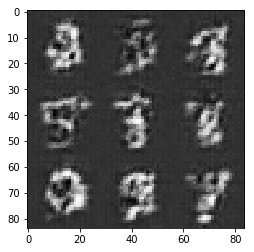

Epoch 1/2... Discriminator Loss: 0.2725... Generator Loss: 1.8961
Epoch 1/2... Discriminator Loss: 0.1838... Generator Loss: 3.0817
Epoch 1/2... Discriminator Loss: 0.1531... Generator Loss: 2.5441
Epoch 1/2... Discriminator Loss: 0.2030... Generator Loss: 2.4020


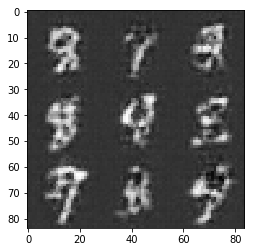

Epoch 1/2... Discriminator Loss: 0.1400... Generator Loss: 2.5842
Epoch 1/2... Discriminator Loss: 0.1920... Generator Loss: 2.3279
Epoch 1/2... Discriminator Loss: 0.2954... Generator Loss: 1.7550
Epoch 1/2... Discriminator Loss: 0.1404... Generator Loss: 2.7228


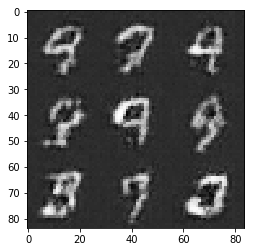

Epoch 1/2... Discriminator Loss: 0.1223... Generator Loss: 3.1051
Epoch 1/2... Discriminator Loss: 0.2621... Generator Loss: 1.8738
Epoch 1/2... Discriminator Loss: 0.3833... Generator Loss: 1.6412
Epoch 1/2... Discriminator Loss: 0.2066... Generator Loss: 2.8610


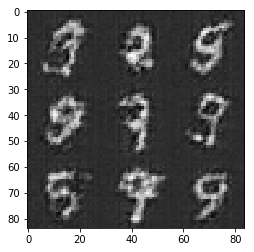

Epoch 1/2... Discriminator Loss: 0.2605... Generator Loss: 2.1642
Epoch 1/2... Discriminator Loss: 0.1722... Generator Loss: 2.5104
Epoch 1/2... Discriminator Loss: 0.7522... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 1.1116


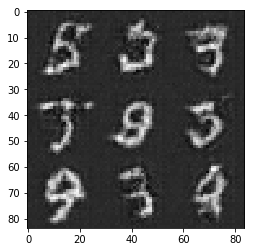

Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 1.6283
Epoch 1/2... Discriminator Loss: 0.3834... Generator Loss: 1.3749
Epoch 1/2... Discriminator Loss: 0.1115... Generator Loss: 3.7486
Epoch 1/2... Discriminator Loss: 0.6610... Generator Loss: 1.0483


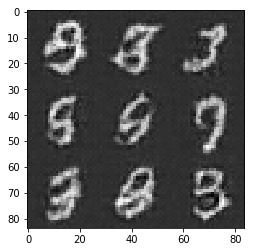

Epoch 1/2... Discriminator Loss: 0.2647... Generator Loss: 1.8666
Epoch 1/2... Discriminator Loss: 0.2325... Generator Loss: 2.2933
Epoch 1/2... Discriminator Loss: 0.2298... Generator Loss: 1.9930
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 5.3623


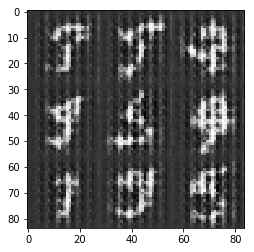

Epoch 1/2... Discriminator Loss: 0.1388... Generator Loss: 2.8303
Epoch 2/2... Discriminator Loss: 0.2464... Generator Loss: 2.1390
Epoch 2/2... Discriminator Loss: 0.2318... Generator Loss: 2.0028
Epoch 2/2... Discriminator Loss: 0.3125... Generator Loss: 1.7579


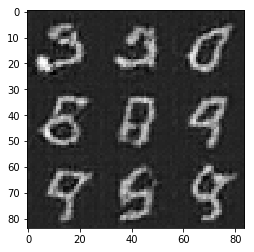

Epoch 2/2... Discriminator Loss: 0.4275... Generator Loss: 1.3464
Epoch 2/2... Discriminator Loss: 0.1538... Generator Loss: 2.8630
Epoch 2/2... Discriminator Loss: 0.2248... Generator Loss: 1.9999
Epoch 2/2... Discriminator Loss: 0.1365... Generator Loss: 2.7824


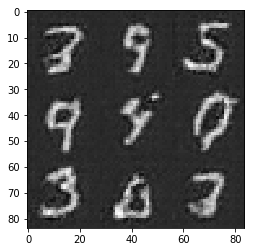

Epoch 2/2... Discriminator Loss: 0.3448... Generator Loss: 1.8180
Epoch 2/2... Discriminator Loss: 0.2696... Generator Loss: 2.1000
Epoch 2/2... Discriminator Loss: 0.0994... Generator Loss: 3.1557
Epoch 2/2... Discriminator Loss: 0.3145... Generator Loss: 1.9780


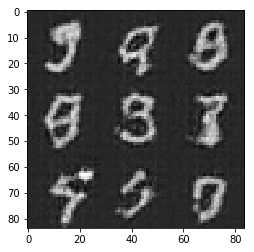

Epoch 2/2... Discriminator Loss: 0.1691... Generator Loss: 2.5169
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 3.2733
Epoch 2/2... Discriminator Loss: 0.2981... Generator Loss: 1.9853
Epoch 2/2... Discriminator Loss: 0.2734... Generator Loss: 1.9072


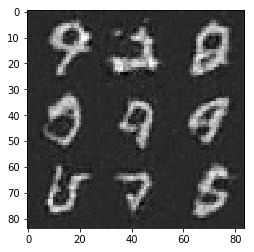

Epoch 2/2... Discriminator Loss: 0.2790... Generator Loss: 1.8651
Epoch 2/2... Discriminator Loss: 0.2436... Generator Loss: 2.5862
Epoch 2/2... Discriminator Loss: 0.3009... Generator Loss: 2.0844
Epoch 2/2... Discriminator Loss: 0.1984... Generator Loss: 2.1597


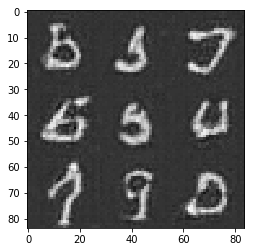

Epoch 2/2... Discriminator Loss: 0.1854... Generator Loss: 4.9912
Epoch 2/2... Discriminator Loss: 0.1918... Generator Loss: 2.2998
Epoch 2/2... Discriminator Loss: 0.2106... Generator Loss: 2.1273
Epoch 2/2... Discriminator Loss: 0.1089... Generator Loss: 2.9464


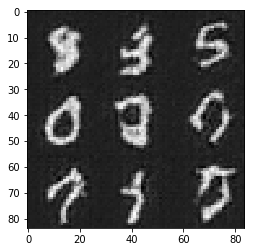

Epoch 2/2... Discriminator Loss: 0.1509... Generator Loss: 2.6380
Epoch 2/2... Discriminator Loss: 0.3128... Generator Loss: 1.7361
Epoch 2/2... Discriminator Loss: 0.1316... Generator Loss: 2.8443
Epoch 2/2... Discriminator Loss: 2.2569... Generator Loss: 0.3089


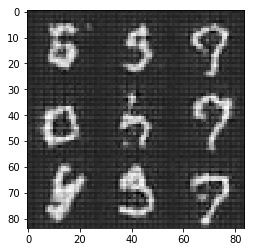

Epoch 2/2... Discriminator Loss: 0.1962... Generator Loss: 2.4420
Epoch 2/2... Discriminator Loss: 0.4158... Generator Loss: 1.5123
Epoch 2/2... Discriminator Loss: 0.1917... Generator Loss: 2.2422
Epoch 2/2... Discriminator Loss: 0.0595... Generator Loss: 3.4397


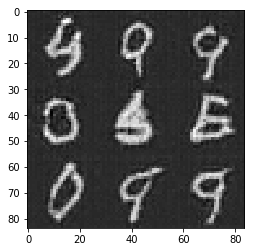

Epoch 2/2... Discriminator Loss: 0.2829... Generator Loss: 1.8360
Epoch 2/2... Discriminator Loss: 0.1647... Generator Loss: 2.5234
Epoch 2/2... Discriminator Loss: 0.2292... Generator Loss: 2.0727
Epoch 2/2... Discriminator Loss: 0.1664... Generator Loss: 2.7525


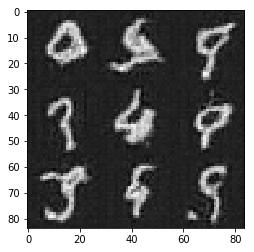

Epoch 2/2... Discriminator Loss: 0.2696... Generator Loss: 2.1560
Epoch 2/2... Discriminator Loss: 0.1948... Generator Loss: 2.2821
Epoch 2/2... Discriminator Loss: 0.0745... Generator Loss: 3.8030


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    #tf.reset_default_graph()
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.9181... Generator Loss: 5.6929
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 2.0011
Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 1.3951


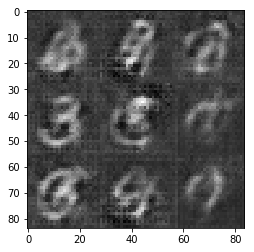

Epoch 2/2... Discriminator Loss: 0.5482... Generator Loss: 1.2491
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.4687
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 0.1526... Generator Loss: 2.7363


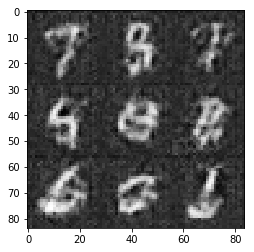

Epoch 2/2... Discriminator Loss: 0.5838... Generator Loss: 1.3877


In [17]:
batch_size = 256
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    #tf.reset_default_graph()
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 1.3126
Epoch 1/1... Discriminator Loss: 0.0999... Generator Loss: 3.4694
Epoch 1/1... Discriminator Loss: 2.4736... Generator Loss: 0.1187
Epoch 1/1... Discriminator Loss: 0.0326... Generator Loss: 9.8620


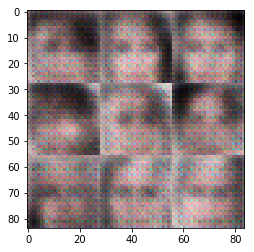

Epoch 1/1... Discriminator Loss: 0.0642... Generator Loss: 8.1970
Epoch 1/1... Discriminator Loss: 0.1217... Generator Loss: 6.8128
Epoch 1/1... Discriminator Loss: 0.2239... Generator Loss: 2.4941
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.2957


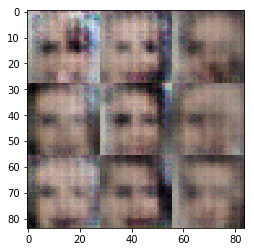

Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 13.5632
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 3.7651
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 11.4671


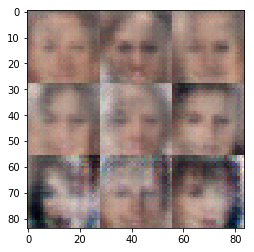

Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 0.6870... Generator Loss: 1.8410
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 1.4531


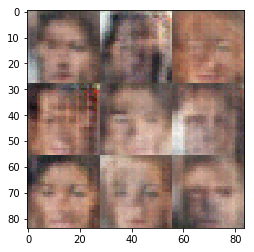

Epoch 1/1... Discriminator Loss: 1.8758... Generator Loss: 0.2923
Epoch 1/1... Discriminator Loss: 0.1123... Generator Loss: 3.4277
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 0.2529... Generator Loss: 1.8351


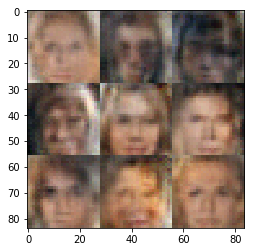

Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.2847
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.1602


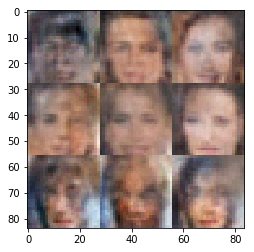

Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 2.0537
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 1.0381


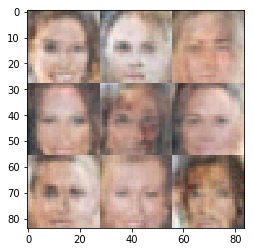

Epoch 1/1... Discriminator Loss: 2.1231... Generator Loss: 0.1494
Epoch 1/1... Discriminator Loss: 2.1350... Generator Loss: 0.1545
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.5736


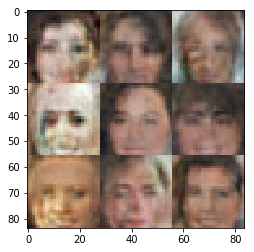

Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.5448


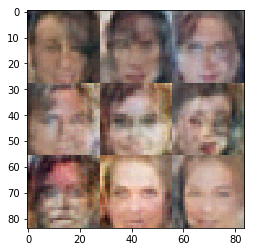

Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 4.4784
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.4854


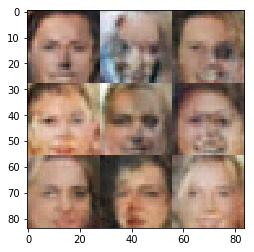

Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 0.9672


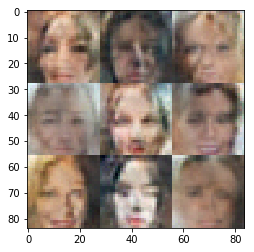

Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.8258
Epoch 1/1... Discriminator Loss: 1.7995... Generator Loss: 0.2336
Epoch 1/1... Discriminator Loss: 2.3894... Generator Loss: 0.1360


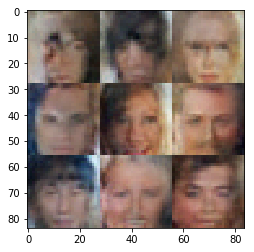

Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 0.3562... Generator Loss: 3.3822
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.4220


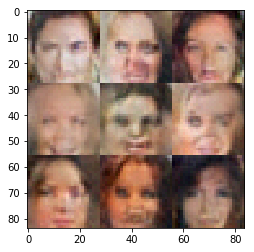

Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 1.0758


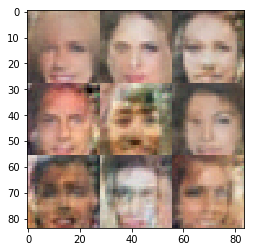

Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 2.2775
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.4932
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.4660


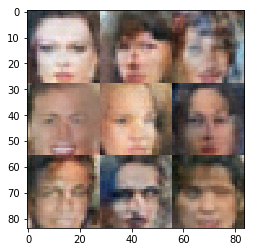

Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 2.0552
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.0890


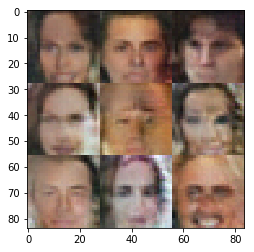

Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 1.6138... Generator Loss: 0.3310
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.5680


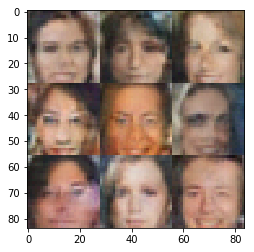

Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.6260


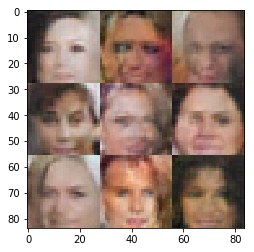

Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.5074


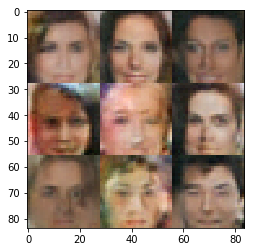

Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.6021


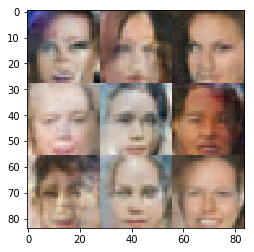

Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.6767... Generator Loss: 0.2987
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.5792


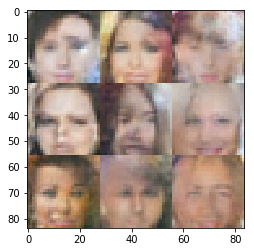

Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 6.2275


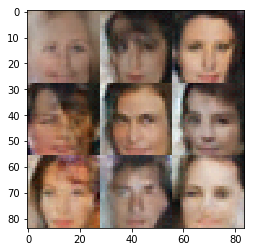

Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 2.1278... Generator Loss: 0.7273


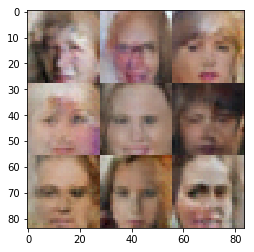

Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7901


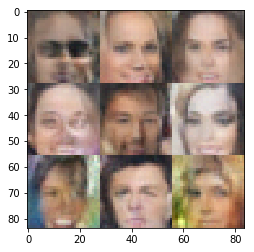

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.4676
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.5305


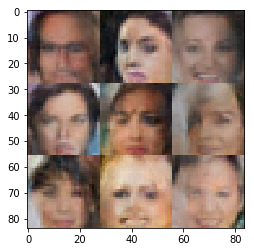

Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.6415... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.4637


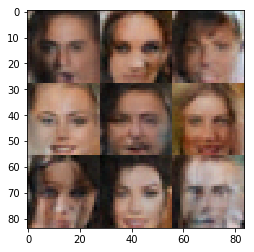

Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.7415... Generator Loss: 0.4703


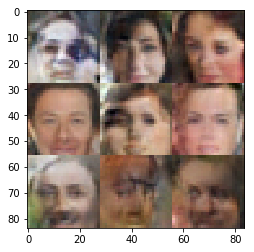

Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.5562
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6106


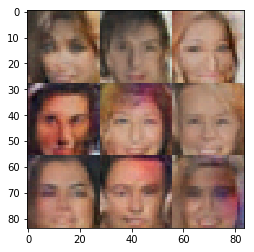

Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 1.2736
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 1.5369
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.5681


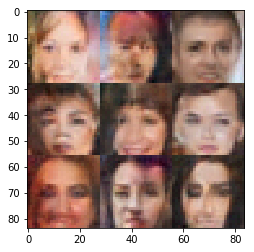

Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.3534
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 1.0239


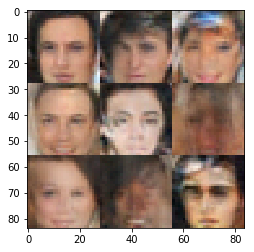

Epoch 1/1... Discriminator Loss: 1.7084... Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.4341
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.4393


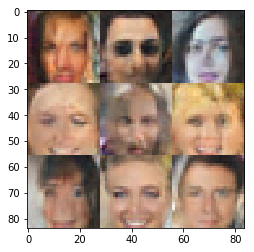

Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.3249


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.